
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pytextbook/pytextbook/blob/main/5.0.%20klue-classification.ipynb)

## 기초 분류 모델 만들기

## 라이브러리 설치
필요 라이브러리 설치를 위해 아래에 주석 처리(#)을 지우고 셀 왼쪽에 셀 실행 버튼(세모 모양)을 눌러 실행한다.


● # koreanize-matplotlib : 한글폰트 사용을 위해    
● tqdm : 오래 걸리는 작업의 진행상태를 보기 위해     
● konlpy : 한국어 형태소 분석을 위해           


In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 불러온다.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install koreanize-matplotlib
!pip install konlpy --upgrade
!pip install tqdm --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 10.3 MB/s eta 0:00:00


필요 라이브러리를 미리 임포트해 둔다.

## 시각화를 위한 폰트 설정


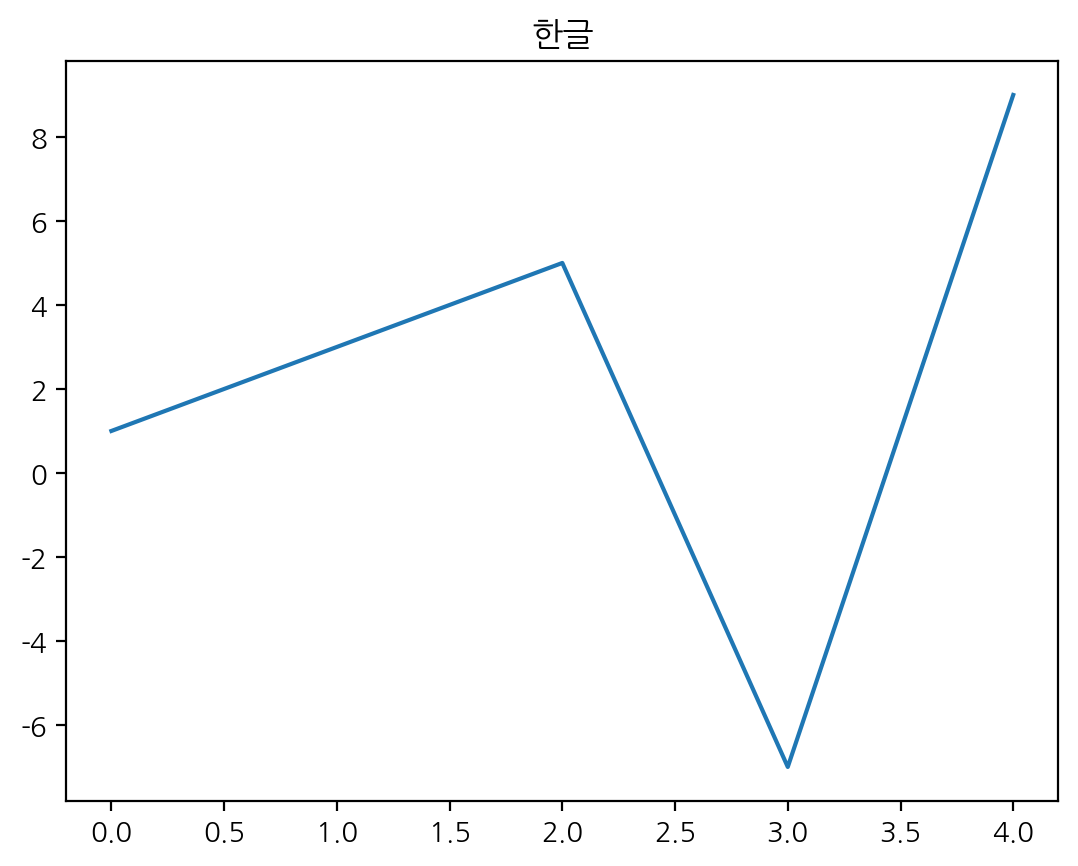

In [4]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

pd.Series([1, 3, 5, -7, 9]).plot(title="한글")
plt.show()

## 데이터 로드

In [5]:
# 데이콘의 해당 데이터셋은 CC-BY-4.0 라이센스입니다.
# 데이터 출처 : https://dacon.io/competitions/official/235747/data
# 로컬 PC에서 실습 시 직접 데이콘 사이트에 회원가입하고 다운로드 해주세요.

import os, platform

base_path = "data/klue/"
file_name = "dacon-klue-open-zip"

def file_exist_check(base_path):
    if os.path.exists(f"{base_path}train_data.csv"):
        print(f"{os.getcwd()}/{base_path} 경로에 파일이 있음")
        return

    if not os.path.exists(base_path):
        os.makedirs(base_path)

    if platform.system() == "Linux":
        print(f"파일을 다운로드 하고 {base_path} 경로에 압축을 해제함")
        !wget https://bit.ly/{file_name}
        !unzip {file_name} -d {base_path}
        return
    else:
        print(f"""https://dacon.io/competitions/official/235747/data 에서 다운로드 하고
              실습 경로 {os.getcwd()}/{base_path}에 옮겨주세요.""")
        return

file_exist_check(base_path)

파일을 다운로드 하고 data/klue/ 경로에 압축을 해제함
--2024-02-27 06:24:01--  https://bit.ly/dacon-klue-open-zip
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC [following]
--2024-02-27 06:24:01--  https://drive.google.com/uc?export=download&id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC
Resolving drive.google.com (drive.google.com)... 142.250.145.102, 142.250.145.101, 142.250.145.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.145.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC&export=download [following]
--2024-02-27 06:24:01--  https://drive.usercontent.google.com/download?id=1jPnwbGKd4eCIZzt5fZshyPf4stGdvcJC&export=download
Resolving drive.userconte

In [6]:
# 학습, 예측 데이터셋을 불러온다.
modeling_data_Xy = pd.read_csv(os.path.join(base_path, "train_data.csv"))
submission_data_X = pd.read_csv(os.path.join(base_path, "test_data.csv"))
modeling_data_Xy.shape, submission_data_X.shape

((45654, 3), (9131, 2))

In [7]:
# 토픽을 불러온다.
topic = pd.read_csv(os.path.join(base_path, "topic_dict.csv"))
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


head()와 tail()로 데이터의 전체적인 모양새 확인

In [8]:
modeling_data_Xy.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4


In [9]:
submission_data_X.head()

,index,title
0,45654,유튜브 내달 2일까지 크리에이터 지원 공간 운영
1,45655,어버이날 맑다가 흐려져…남부지방 옅은 황사
2,45656,내년부터 국가RD 평가 때 논문건수는 반영 않는다
3,45657,김명자 신임 과총 회장 원로와 젊은 과학자 지혜 모을 것
4,45658,회색인간 작가 김동식 양심고백 등 새 소설집 2권 출간


In [10]:
topic["topic"].values

array(['IT과학', '경제', '사회', '생활문화', '세계', '스포츠', '정치'], dtype=object)

## 전처리를 위한 데이터 병합

In [11]:
# 전처리를 위해 데이터 병합
raw = pd.concat([modeling_data_Xy, submission_data_X])
raw.shape

(54785, 3)

In [12]:
raw.head()

,index,title,topic_idx
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0


In [13]:
raw.tail()

,index,title,topic_idx
9126,54780,인천 오후 3시35분 대설주의보…눈 3.1cm 쌓여,NaN
9127,54781,노래방에서 지인 성추행 외교부 사무관 불구속 입건종합,NaN
9128,54782,40년 전 부마항쟁 부산 시위 사진 2점 최초 공개,NaN
9129,54783,게시판 아리랑TV 아프리카개발은행 총회 개회식 생중계,NaN
9130,54784,유영민 과기장관 강소특구는 지역 혁신의 중심…지원책 강구,NaN


In [14]:
df = raw.merge(topic, how="left")
df.shape

(54785, 4)

In [15]:
df.head()

,index,title,topic_idx,topic
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계


## 정답값 빈도수

In [16]:
# test는 결측치로 되어 있기 때문에 빈도수에 포함되지 않습니다.
df["topic_idx"].value_counts()

4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64

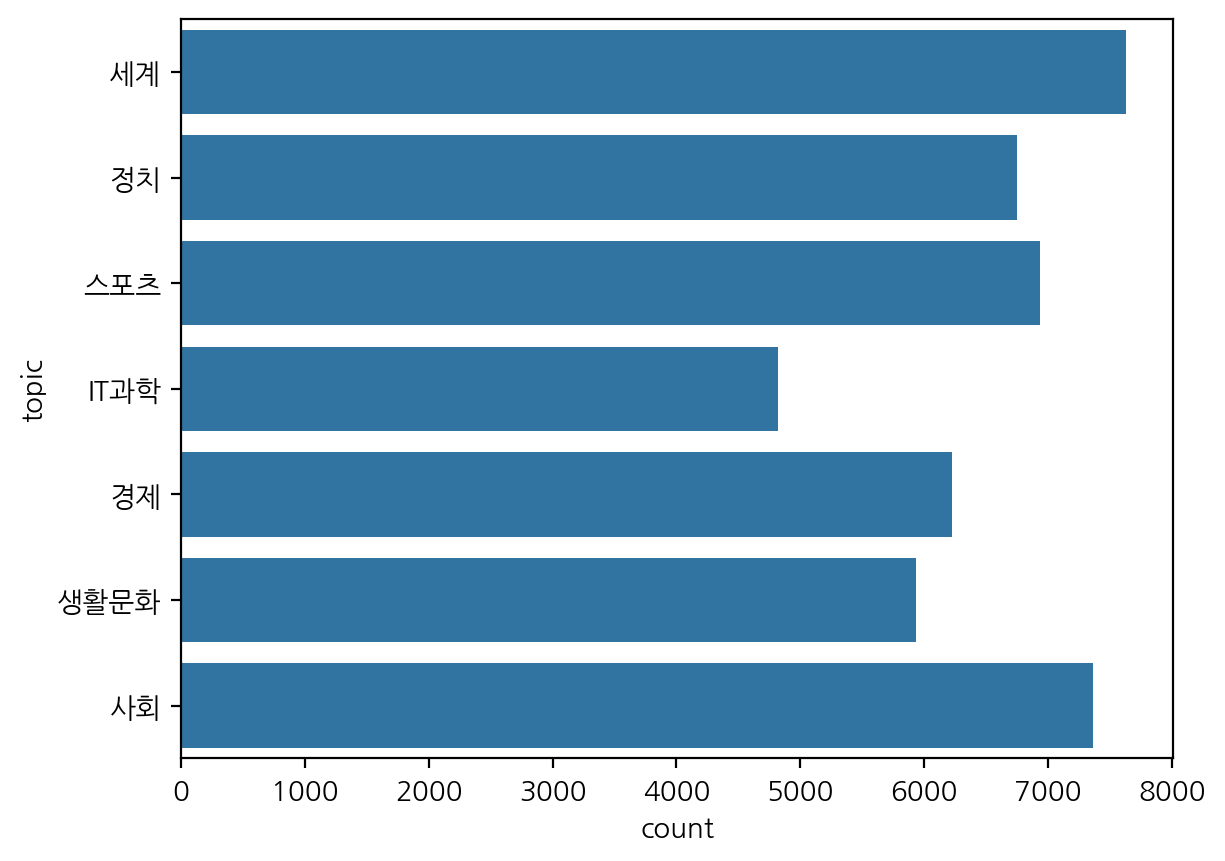

In [18]:
# df 로 빈도수를 구했지만 test 데이터는 topic이 결측치라 포함되지 않습니다.
sns.countplot(data=df, y="topic")
plt.show()

## 문자 길이

In [19]:
# 문자 길이, 단어 빈도, 유일 어절의 빈도수를 알기 위한 파생 변수 만들기
df["len"] = df["title"].apply(lambda x : len(x))
df["word_count"] = df["title"].apply(lambda x : len(x.split()))
df["unique_word_count"] = df["title"].apply(lambda x : len(set(x.split())))

In [20]:
# 파생변수가 잘 만들어졌는지 확인한다.
df.head()

,index,title,topic_idx,topic,len,word_count,unique_word_count
0,0,인천→핀란드 항공기 결항…휴가철 여행객 분통,4.0,세계,24,5,5
1,1,실리콘밸리 넘어서겠다…구글 15조원 들여 美전역 거점화,4.0,세계,30,6,6
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4.0,세계,30,8,8
3,3,NYT 클린턴 측근韓기업 특수관계 조명…공과 사 맞물려종합,4.0,세계,32,7,7
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4.0,세계,25,7,7


 ##  맷플롯립(matplotlib)과 시본(seaborn)을 이용을 이용해 히스토그램으로 시각화

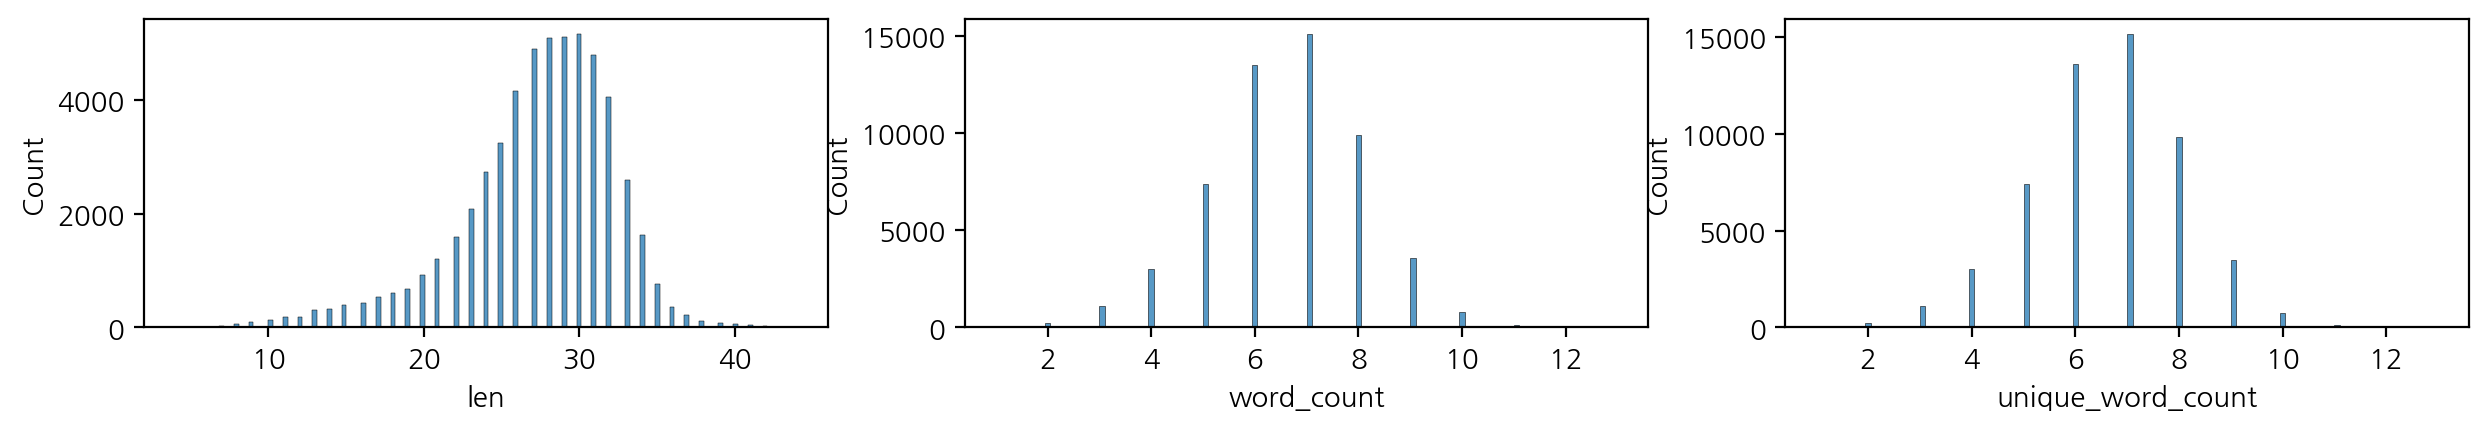

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
sns.histplot(df["len"], ax=axes[0])
sns.histplot(df["word_count"], ax=axes[1])
sns.histplot(df["unique_word_count"], ax=axes[2])
plt.show()

In [22]:
df[["len", "word_count", "unique_word_count"]].describe()

,len,word_count,unique_word_count
count,54785.000000,54785.000000,54785.000000
mean,27.318846,6.587880,6.576198
std,4.947738,1.471852,1.465320
min,4.000000,1.000000,1.000000
25%,25.000000,6.000000,6.000000
50%,28.000000,7.000000,7.000000
75%,31.000000,8.000000,8.000000
max,44.000000,13.000000,13.000000


### 주제별 글자와 단어 수 확인

### 낱글자의 길이(len) 빈도

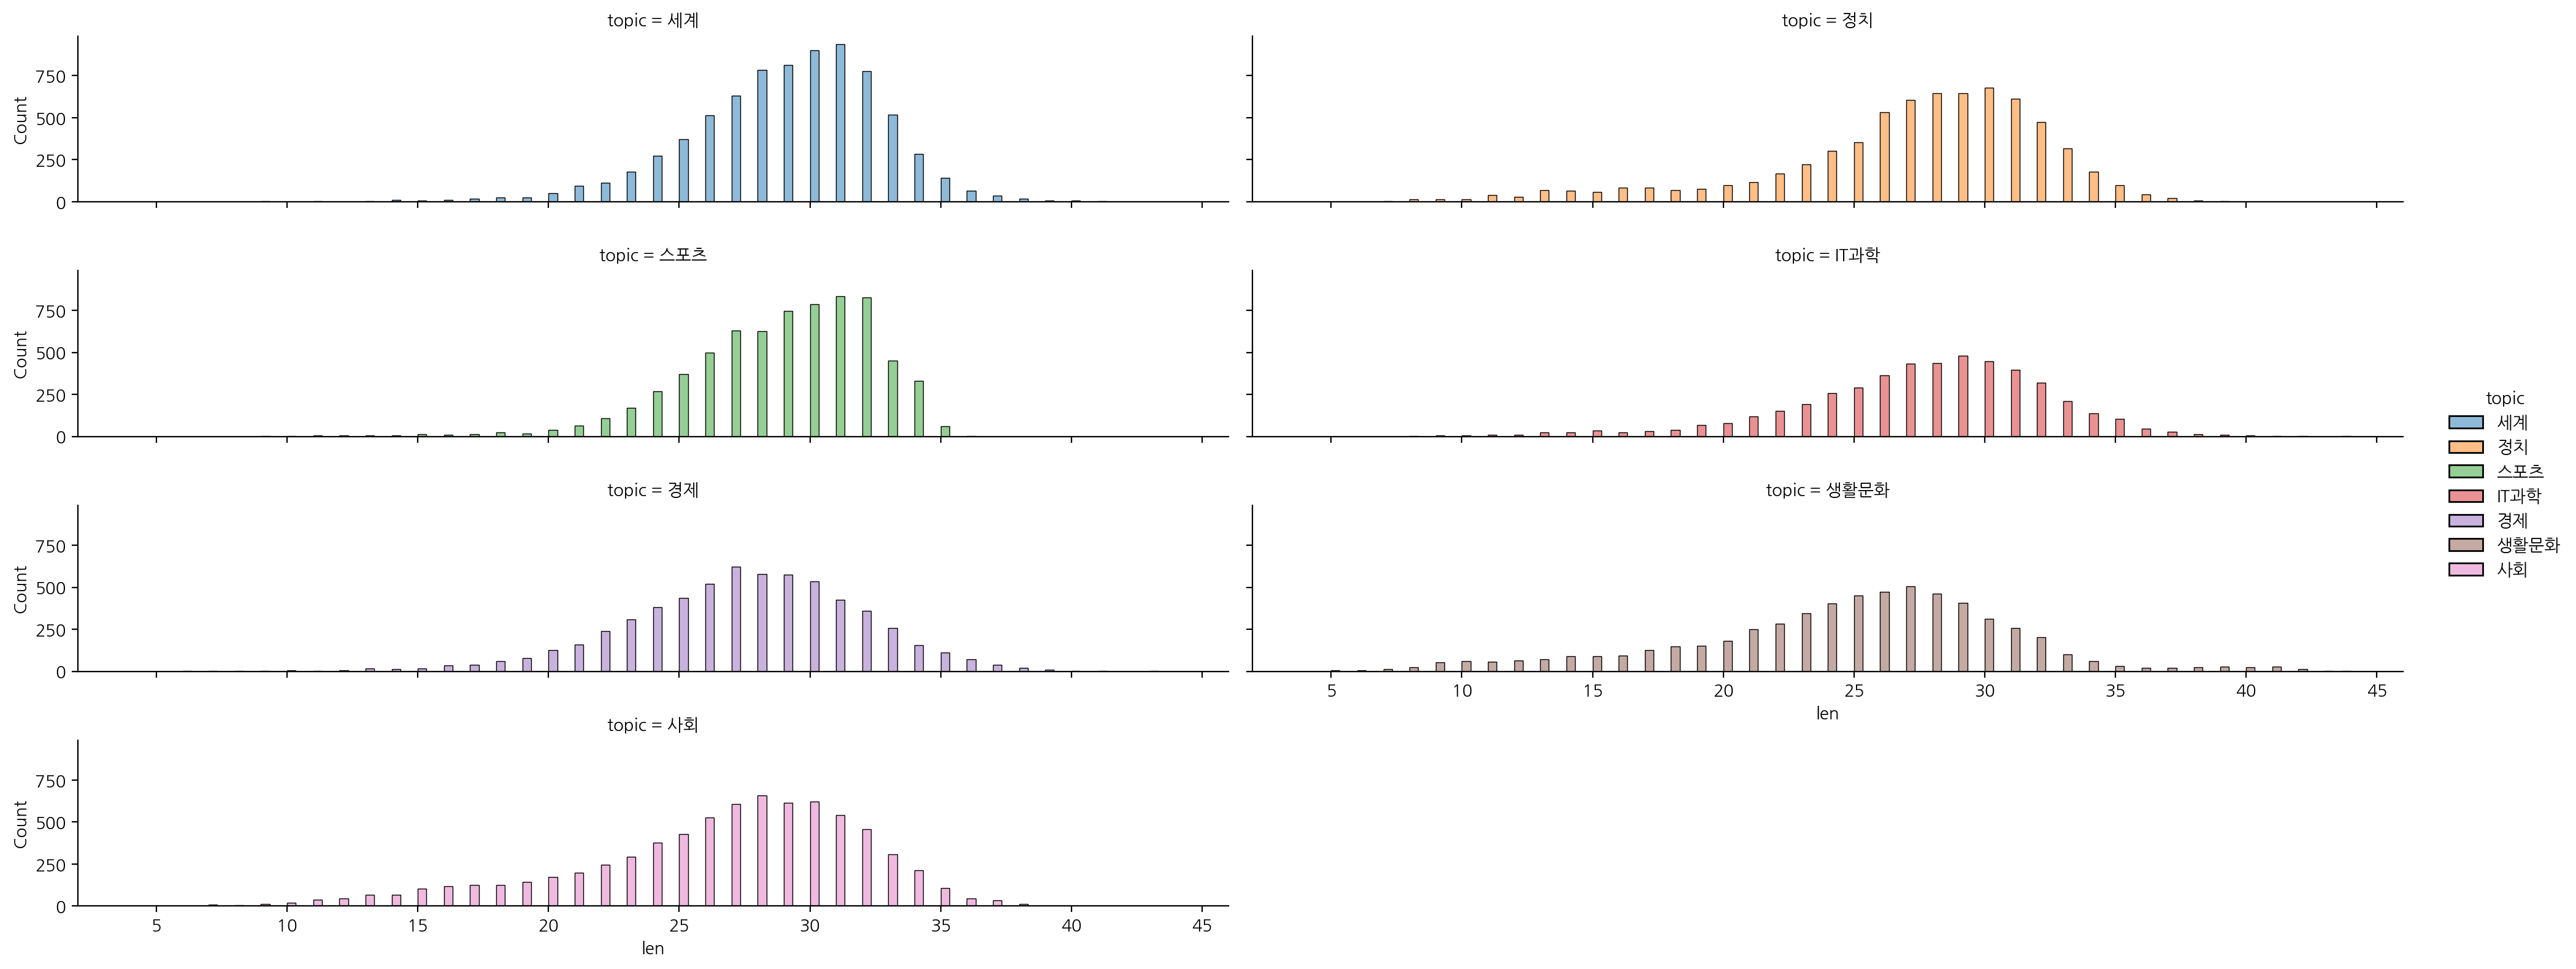

In [23]:
sns.displot(data=df, x="len",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)
plt.show()

### 단어 빈도

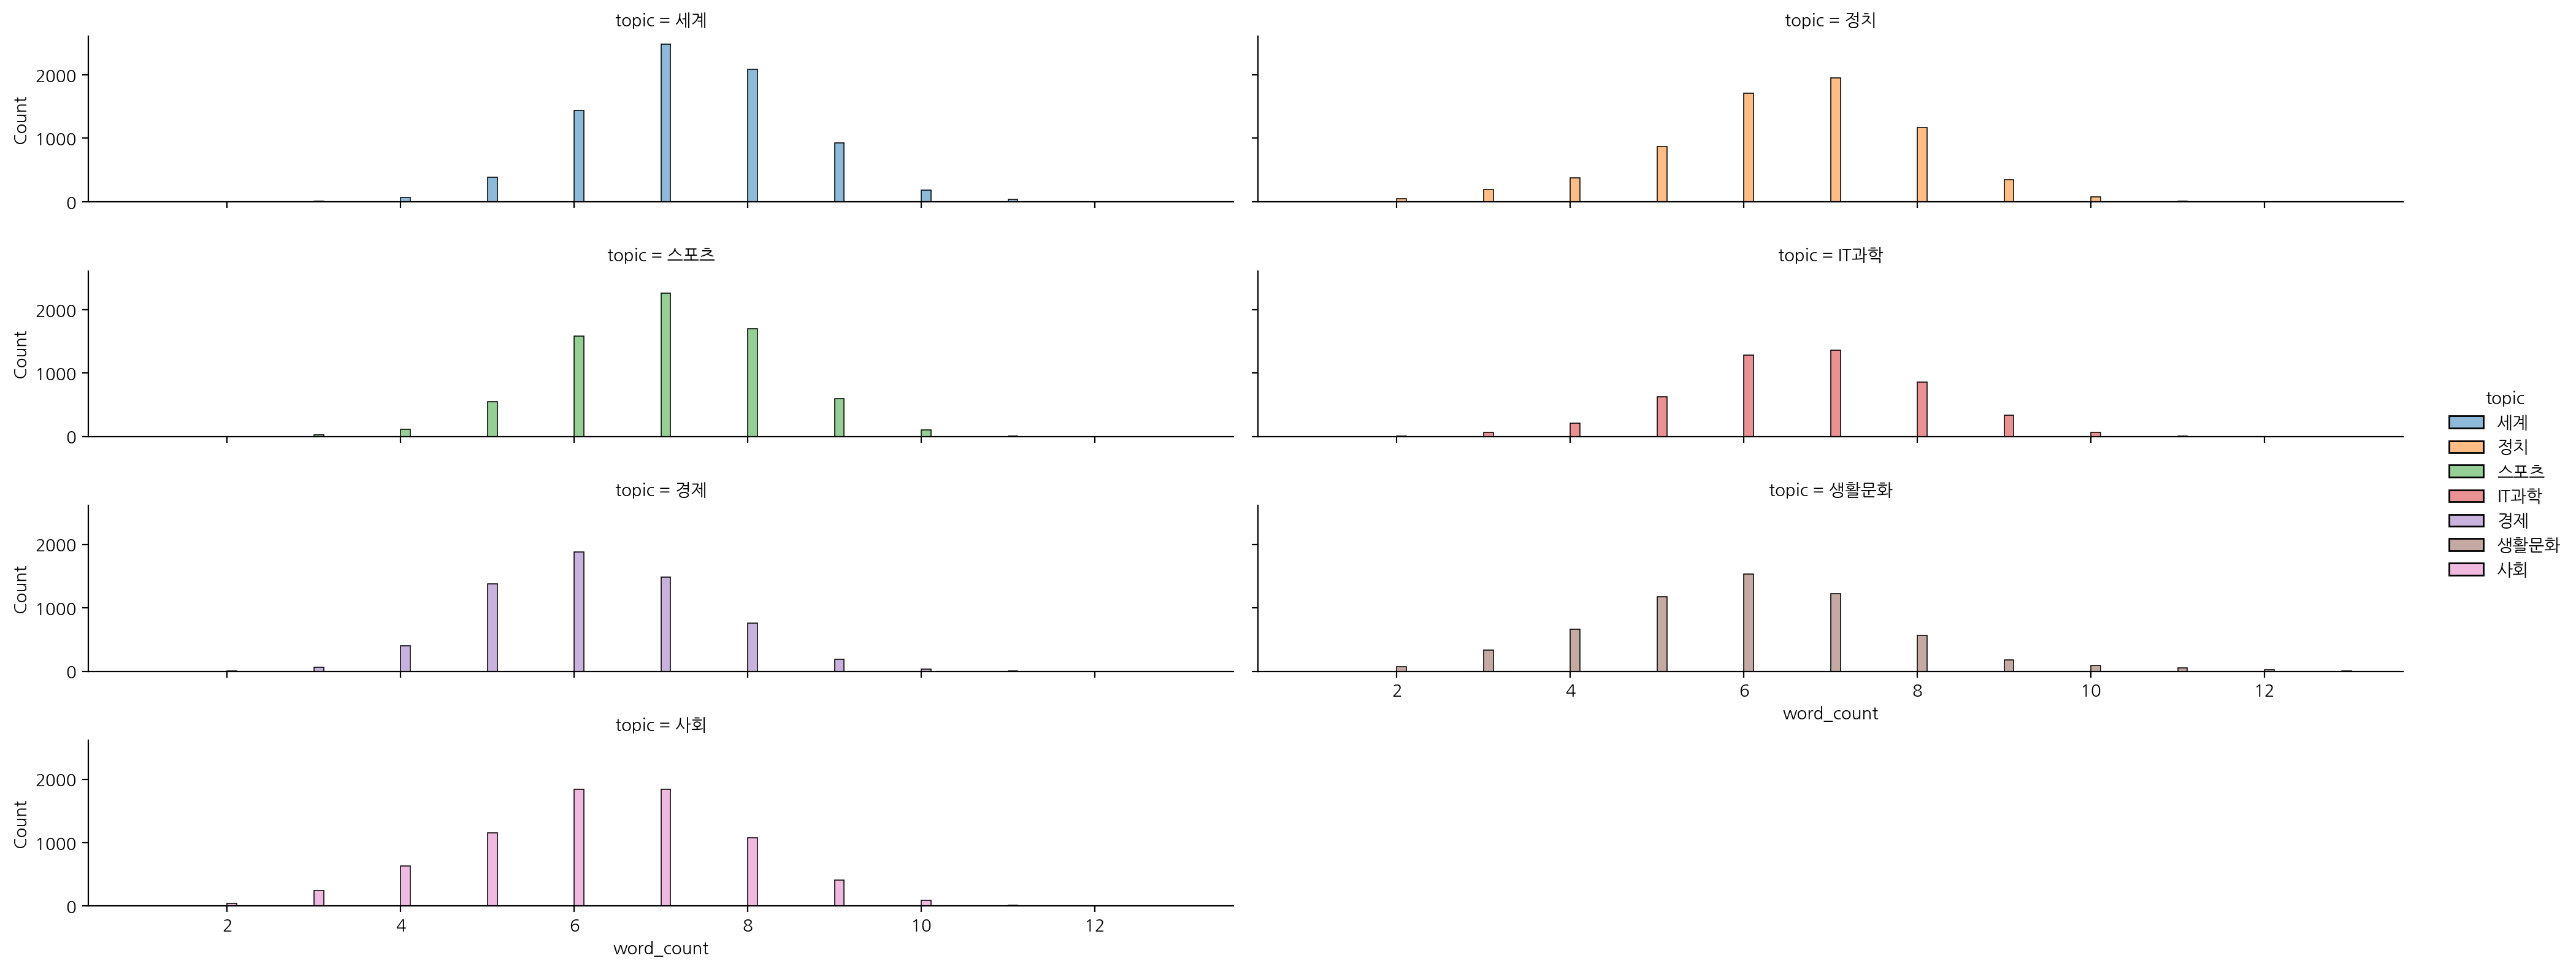

In [24]:
sns.displot(data=df, x="word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)
plt.show()

유일 어절의 빈도

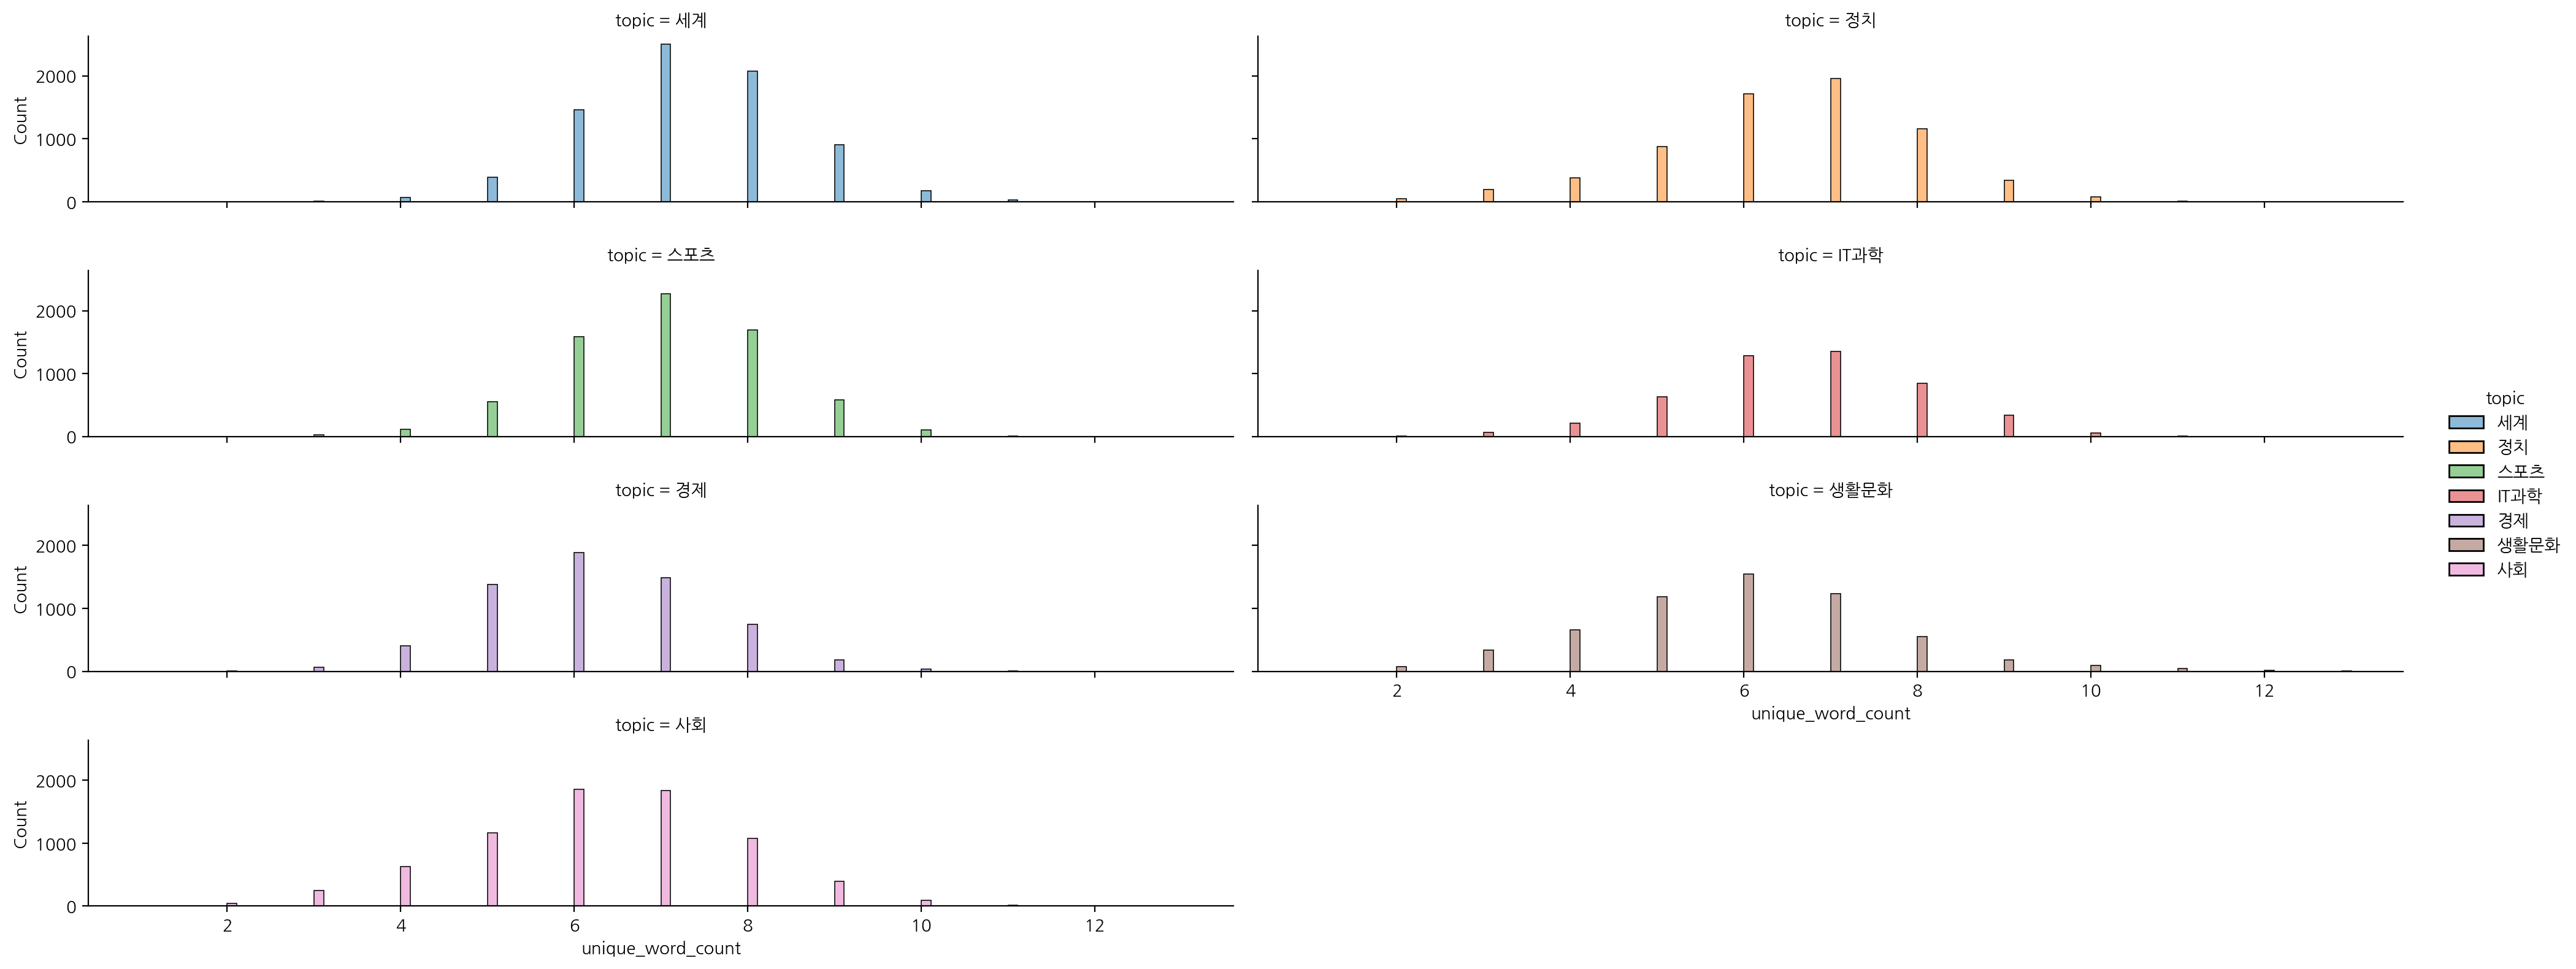

In [25]:
sns.displot(data=df, x="unique_word_count",
            hue="topic", col="topic", col_wrap=2, aspect=5, height=2)
plt.show()

## 문자 전처리

### 숫자 제거

In [30]:
import re
# df["title"] = df["title"].map(lambda x : re.sub("[0-9]", "", x))
# df["title"] = df["title"].str.replace("[0-9]", "", regex=True)
df['title'] = df['title'].str.replace('-?[0-9]+\.?[0-9]+?|-?[0-9]+', '', regex=True)

### 영문자는 모두 소문자로 변경

대소문자가 섞여 있으면 다른 다른 단어로 다루기 때문에 영문자는 모두 대문자 혹은 소문자로 변경합니다.

In [31]:
df["title"] = df["title"].str.lower()

### 조사, 어미, 구두점 제거

조나나 어미를 제거하기 위해 문장에 품사 정보를 부착해서 분리할 수 있도록 형태소 분석기를 부착할 것이다. 형태소 분석기는 Konlpy의 OKT 분석기를 쓸 예정이다.

In [32]:
# 형태소 분석기에서 Okt 태거 불러오기

from konlpy.tag import Okt
okt = Okt()

# 어간 추출(stemming) : 조사, 어미, 구두점 제거
def okt_clean(text):
    clean_text = []
    for word in okt.pos(text, stem=True):
        if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
            clean_text.append(word[0])

    return " ".join(clean_text)

from tqdm import tqdm
tqdm.pandas()

modeling_data_Xy['title'] = modeling_data_Xy['title'].progress_map(okt_clean)
submission_data_X['title'] = submission_data_X['title'].progress_map(okt_clean)

100%|██████████| 9131/9131 [00:12<00:00, 713.36it/s]


### 불용어 제거

In [33]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다',
             '그리고', '입니다', '그 ', ' 등', '이런', ' 것 ', ' 및 ',' 제 ', ' 더 ']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [34]:
df["title"] = df["title"].map(remove_stopwords)

## 학습, 시험 데이터 세트 분리

학습 데이터 세트와 시험 데이터 세트로 다시 분리한다. 정답값인 topic_idx 값 여부에 따라 데이터를 나눌 수 있다.

In [35]:
label_name = "topic_idx"

test의 topic_idx는 NaN이었다. 따라서 notnull()과 isnull()을 사용하여 topic 이 있으면 학습 데이터, 없으면 시험 데이터 세트로 재분할한다.

In [36]:
modeling_data = df[df[label_name].notnull()]
submission_data = df[df[label_name].isnull()]
modeling_data.shape, submission_data.shape

((45654, 7), (9131, 7))

In [37]:
X_modeling = modeling_data["title"]
X_submission = submission_data["title"]

X_modeling.shape, X_submission.shape

((45654,), (9131,))

In [38]:
y_modeling = modeling_data[label_name]
y_modeling.value_counts()

4.0    7629
2.0    7362
5.0    6933
6.0    6751
1.0    6222
3.0    5933
0.0    4824
Name: topic_idx, dtype: int64

In [39]:
y_submission = submission_data[label_name]
y_submission.value_counts()

Series([], Name: topic_idx, dtype: int64)

## 벡터화

### TF-IDF(Term Frequency - Inverse Document Frequency)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_modeling, y_modeling, stratify=y_modeling)

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=None,
                             ngram_range=(1,2),
                             min_df=3,
                             max_df=0.95)
tfidf_vect.fit(X_train)

TfidfVectorizer(max_df=0.95, min_df=3, ngram_range=(1, 2))

In [45]:
train_feature_tfidf = tfidf_vect.transform(X_train)
test_feature_tfidf = tfidf_vect.transform(X_test)

train_feature_tfidf.shape, test_feature_tfidf.shape

((34240, 16784), (11414, 16784))

In [46]:
# 단어 사전
vocab = tfidf_vect.get_feature_names_out()
print(len(vocab))
vocab[:10]

16784


array(['abs', 'acl', 'afc', 'afc 챔스리그', 'afc 챔피언십', 'ag', 'ag 우승', 'ai',
       'ai 개발', 'ai 검색'], dtype=object)

In [47]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더한다. axis=0 으로 한다.
dist = np.sum(train_feature_tfidf, axis=0)

vocab_count = pd.DataFrame(dist, columns=vocab)
vocab_count

,abs,acl,afc,afc 챔스리그,afc 챔피언십,ag,ag 우승,ai,ai 개발,ai 검색,...,힐만 감독,힘겨운,힘내세요,힘든,힘들어,힘으로,힘은,힘찬,女배구,女배구 대표팀
0,1.467823,3.831201,7.496841,2.772393,1.533022,11.535027,1.53651,62.211341,1.920819,1.243539,...,3.454389,1.430409,1.611064,3.585627,1.81061,3.496205,2.551402,1.914618,6.248615,1.52544


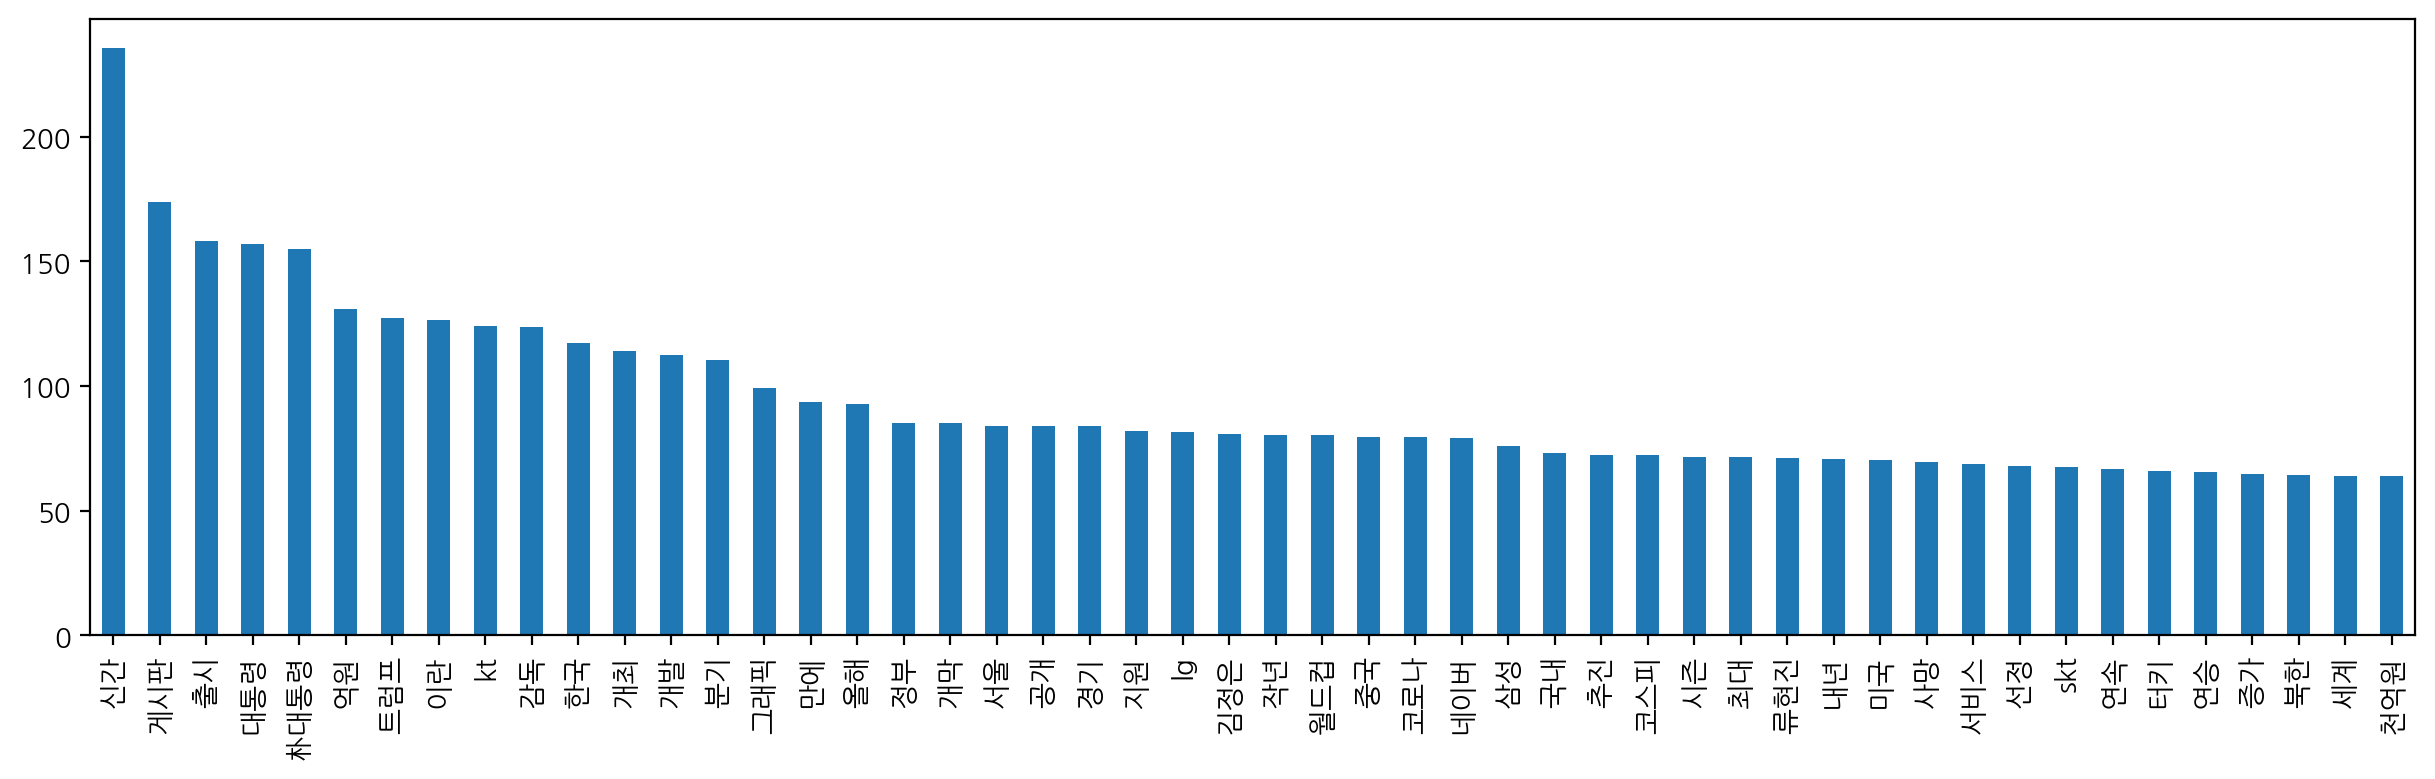

In [49]:
# 위에서 구한 빈도수를 그래프로 그린다.
vocab_count.T[0].sort_values(ascending=False).head(50).plot.bar(figsize=(15, 4))
plt.show()

## 학습과 예측

In [50]:
# RandomForestClassifier 를 불러온다.
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, random_state=42)
model

RandomForestClassifier(n_jobs=-1, random_state=42)

### 교차 검증

In [51]:
from sklearn.model_selection import cross_val_score

cv_results = cross_val_score(model, train_feature_tfidf, y_train, cv=3, n_jobs=-1, verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.9min finished


### 교차 검증 정확도 및 편차

In [52]:
print('cv 정확도', cv_results)
print('평균 정확도', np.mean(cv_results).round(4))
print('정확도 편차', np.std(cv_results).round(4))

cv 정확도 [0.73707727 0.72855516 0.73635328]
평균 정확도 0.734
정확도 편차 0.0039


### 학습


In [53]:
# fit 으로 학습
%time model.fit(train_feature_tfidf, y_train)

CPU times: user 2min 43s, sys: 881 ms, total: 2min 44s
Wall time: 1min 37s


RandomForestClassifier(n_jobs=-1, random_state=42)

### 예측

In [60]:
# predict로 예측
y_predict_train = model.predict(train_feature_tfidf)
y_predict_train[:5]

array([1., 2., 4., 5., 1.])

### 추가 작업(그룹별 정확도)

In [55]:
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


In [77]:
def my_metrics_display(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame({"predictions": y_pred, "ground": y})
    df["accuracy"] = (y_pred == y)
    display(df.groupby(['ground'])['accuracy'].mean())
    return df

In [76]:
df_accuracy_train = my_metrics_display(model, train_feature_tfidf, y_train)

ground
0.0    0.995025
1.0    0.992713
2.0    0.985148
3.0    0.997303
4.0    0.997728
5.0    0.997885
6.0    0.993482
Name: accuracy, dtype: float64

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def my_metrics_display2(model, X, y):
    df = my_metrics_display(model, X, y)
    print(classification_report(df['ground'], df['predictions'], target_names=topic['topic']))
    cm = confusion_matrix(df['ground'], df['predictions'])
    print(cm)
    disp = ConfusionMatrixDisplay(cm, display_labels=topic['topic'])
    disp2 = ConfusionMatrixDisplay.from_predictions(df['ground'], df['predictions'], display_labels=topic['topic'])
    disp.plot()
    plt.show()

    return df

ground
0.0    0.995025
1.0    0.992713
2.0    0.985148
3.0    0.997303
4.0    0.997728
5.0    0.997885
6.0    0.993482
Name: accuracy, dtype: float64

              precision    recall  f1-score   support

        IT과학       1.00      1.00      1.00      3618
          경제       1.00      0.99      0.99      4666
          사회       1.00      0.99      0.99      5521
        생활문화       0.97      1.00      0.98      4450
          세계       1.00      1.00      1.00      5722
         스포츠       1.00      1.00      1.00      5200
          정치       1.00      0.99      1.00      5063

    accuracy                           0.99     34240
   macro avg       0.99      0.99      0.99     34240
weighted avg       0.99      0.99      0.99     34240

[[3600    3    4   11    0    0    0]
 [   2 4632    6   22    1    0    3]
 [   3    7 5439   63    1    2    6]
 [   1    1   10 4438    0    0    0]
 [   0    0    2   10 5709    0    1]
 [   1    0    1    9    0 5189    0]
 [   0    2    3   26    2    0 5030]]


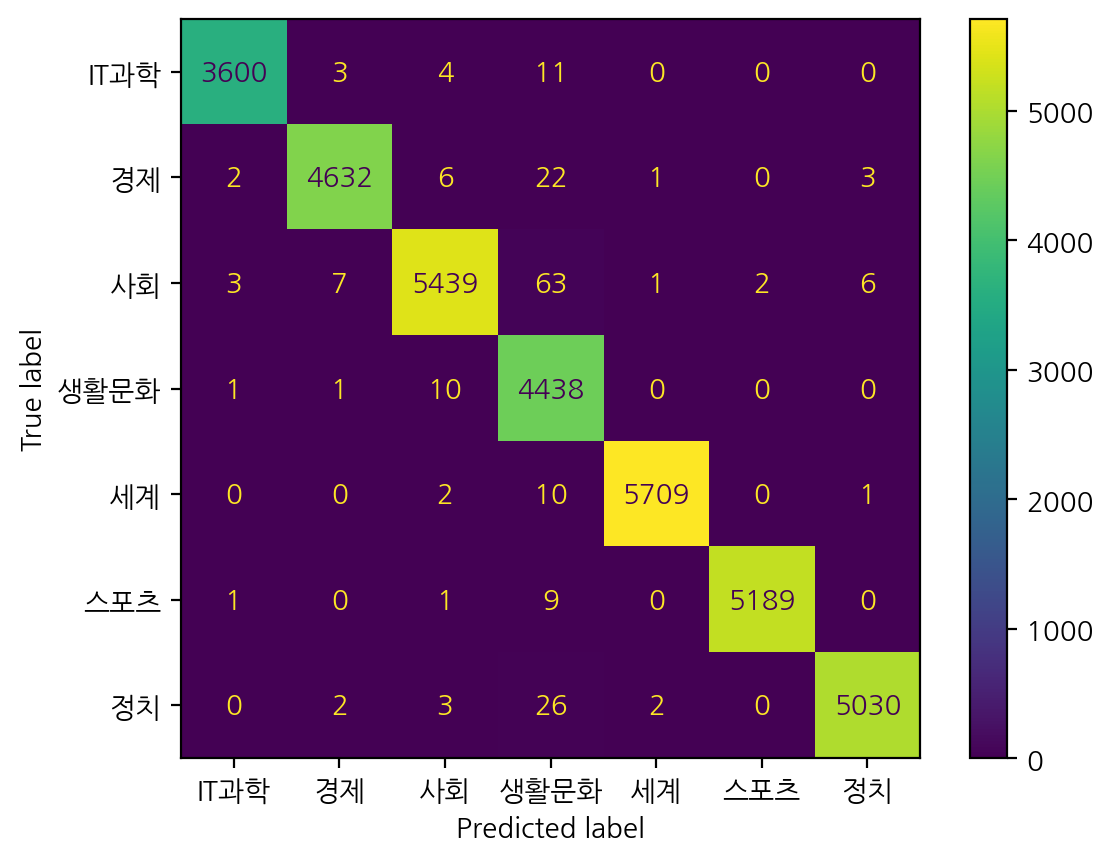

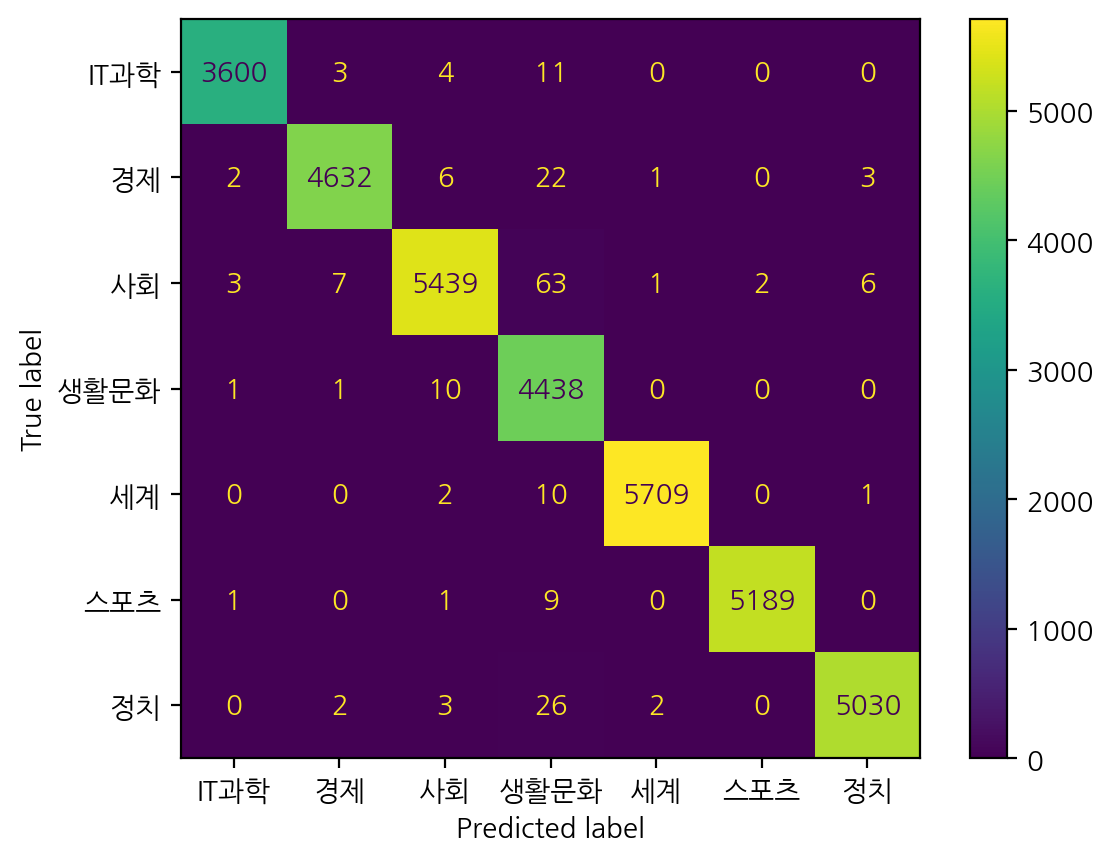

In [104]:
df_accuracy_train = my_metrics_display2(model, train_feature_tfidf, y_train)

ground
0.0    0.728856
1.0    0.688303
2.0    0.601847
3.0    0.799056
4.0    0.727845
5.0    0.869590
6.0    0.779621
Name: accuracy, dtype: float64

              precision    recall  f1-score   support

        IT과학       0.68      0.73      0.70      1206
          경제       0.76      0.69      0.72      1556
          사회       0.59      0.60      0.60      1841
        생활문화       0.65      0.80      0.72      1483
          세계       0.81      0.73      0.77      1907
         스포츠       0.92      0.87      0.89      1733
          정치       0.79      0.78      0.78      1688

    accuracy                           0.74     11414
   macro avg       0.74      0.74      0.74     11414
weighted avg       0.75      0.74      0.74     11414

[[ 879   71  121   87   25   10   13]
 [ 156 1071  162   69   57   18   23]
 [ 130  124 1108  224   92   28  135]
 [  43   28  151 1185   37   19   20]
 [  44   63  141   90 1388   44  137]
 [  26   23   47   66   40 1507   24]
 [  23   28  147   90   72   12 1316]]


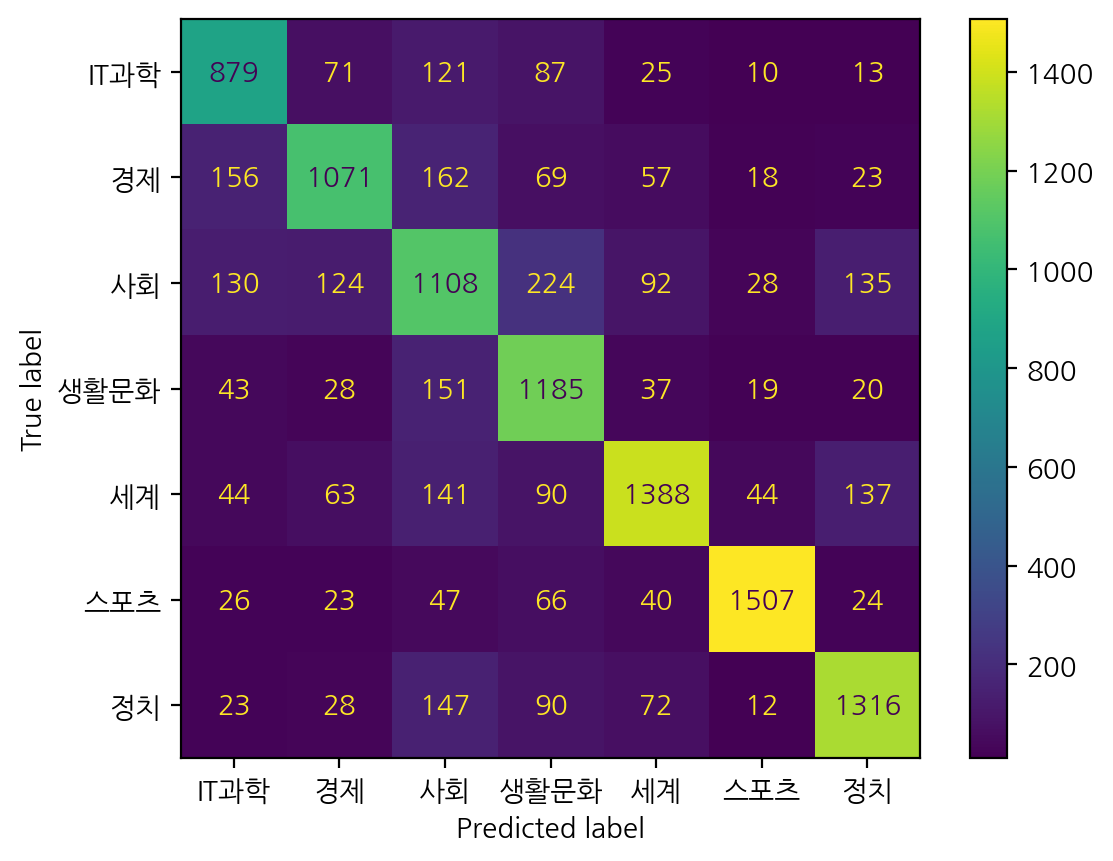

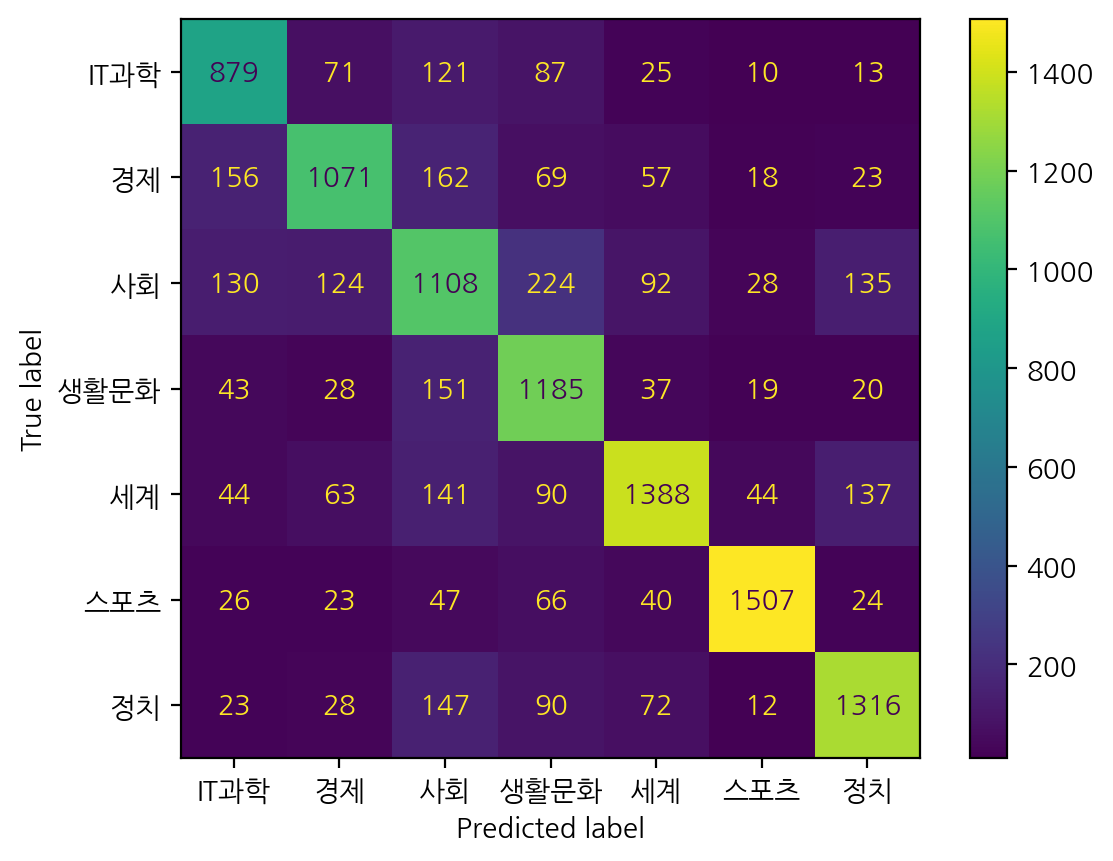

In [105]:
_ = my_metrics_display2(model, test_feature_tfidf, y_test)

## 답안지 로드

sample_submission.csv 파일은 마치 답안지와 같다. 이것을 채워넣어야 한다.

In [106]:
submit = pd.read_csv(os.path.join(base_path, "sample_submission.csv"))
submit.head()

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0


In [109]:
# 정답값 측정을 위해 y_test 변수에 할당
submission_features_tfidf = tfidf_vect.transform(X_submission)
submit["topic_idx"] = model.predict(submission_features_tfidf)

In [110]:
file_name = os.path.join(base_path, f"submit_0.734.csv")
file_name

'data/klue/submit_0.734.csv'

In [111]:
submit.to_csv(file_name, index=False)